In [6]:
from music21 import converter, instrument, note, chord, stream
import tensorflow, numpy

In [7]:
def generate_input_data(song_path):
    
    notes = []
    midi = converter.parse(song_path)
    print("Parsing %s" % song_path)

    # use flat notes only
    notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

    sequence_length = 100

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    n_vocab = len(set(notes))
    network_input = network_input / float(n_vocab)

    network_output = tensorflow.keras.utils.to_categorical(network_output)

    return network_input, network_output, pitchnames, n_vocab

In [8]:
def generate_sequence(model, network_input, pitchnames, n_vocab):

    # pick the last sequence from the input as a starting point for the prediction
    start = -1

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generate 500 notes
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern = numpy.append(pattern, index)
        pattern = pattern[1:len(pattern)]

    return prediction_output

In [9]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output.mid')

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten

In [11]:
# Generate input data from MIDI file
network_input, network_output, pitchnames, n_vocab = generate_input_data('mozart.mid')

/opt/conda/lib/python3.11/site-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(


Parsing mozart.mid


/opt/conda/lib/python3.11/site-packages/music21/stream/base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [12]:
# Define the LSTM model
model = Sequential([
    LSTM(512, input_shape=(network_input.shape[1], network_input.shape[2]), recurrent_dropout=0.3, return_sequences=True),
    LSTM(512, recurrent_dropout=0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(95, activation='softmax')  # 95 should be replaced with n_vocab if the number of notes is different
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

Epoch 1/5
10/10 [==============================] - 23s 2s/step - loss: 3.6861
Epoch 2/5
10/10 [==============================] - 23s 2s/step - loss: 3.6759
Epoch 3/5
10/10 [==============================] - 24s 2s/step - loss: 3.6683
Epoch 4/5
10/10 [==============================] - 24s 2s/step - loss: 3.6751
Epoch 5/5
10/10 [==============================] - 24s 2s/step - loss: 3.6755


Text(0.5, 0, 'Epoch')

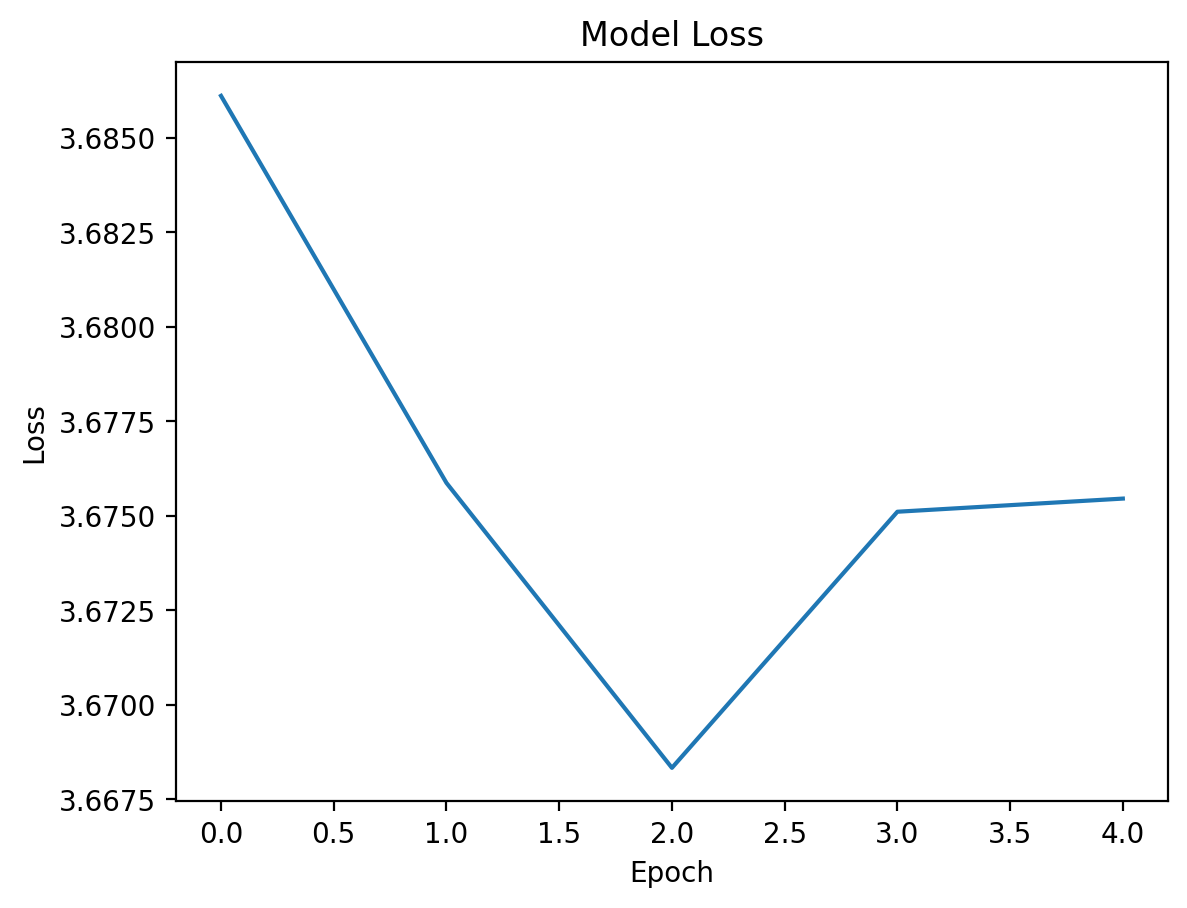

In [14]:
history = model.fit(network_input, network_output, epochs=5, batch_size=256)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [16]:
# Generate a new music sequence
prediction_output = generate_sequence(model, network_input, pitchnames, n_vocab)

# Create a MIDI file from the generated sequence
create_midi(prediction_output)
